#### Final Proposal EDF 6938: Natural Langauge Processing

### Building a Science Concept Recognition System using NLP from Elementary Students’ Science Storybooks   
> #### Author: Lingchen Kong, Jinnie Shin
> #### Date: Dec 05 2022
> #### Email: l.kong@ufl.edu

#### 1. Introduction 

> Concept extraction is the process of detecting phrases in text data that refer to concepts of interest [1]. It is a subtask of information extraction (IE) that allows for the automatic capture of structured information from text, and it has been explored in a variety of domains [2], including news, clinic, engineering, and education.  
<br>In the educational domain, the effective extraction of quality concepts also enables a large body of applications. Examples of such applications include structuring the knowledge and concepts in prerequisite relations, and thus improving educational tasks like curriculum development [3], intelligent tutoring [4], and Automatic Question Generation (AQG). Moreover, extracting science concepts from books will benefit both educators and students in STEM education. By learning and understanding different science concepts and how they are related to each other, students can find it easier to grasp the main ideas of a book. On the other hand, if parents or teachers ask questions centered around science concepts in a book, it in turn encourages active learning as well as helps students to retain important STEM knowledge.<br/>
<br>However, most recent relevant studies mainly focus on extracting general keywords or high-quality phrases, and only a few are devoted to extracting science related concepts from educational data. In this case, this study proposes two unsupervised approaches that automatically extract science concept candidates and classify them into specific science branches. <br/>


#### 2. Related Work 

> Over the last several years, concept extraction has pro-gressed a lot and achieved great performance, and the meth-ods for extracting concepts can typically be categorized into unsupervised approaches and supervised approaches [5]. For traditional ML approaches, text data (concepts) needs to be annotated by experts before training and applying different classifiers. A CRF tagger for name recognition and Ada-Boost for filed identification were proposed to identify medication concepts [6]; For deep learning approaches, Brack et al utilized SciBERT embeddings with a CRF-based sequence tag decoder and BILOU tagging scheme to extract scientific concepts from research articles [7]. For unsupervised approaches, Barker and Cornacchia (2000) examined noun phrases and categorized them as concepts or not based on attributes such as frequency or length [8]; Lu et al applied a graph propagation-based ranking method to identify domain-specific concepts in phrases [9]. However, it is still challenging to extract fine-grained concepts for each science branch, and it is time-consuming and expen-sive to label concepts for learning-based methods.

#### 3. Methods 

> Our analysis was conducted in three stages. First, we extracted the raw text data from each storybook. We used a Python package, PyPDF2, to extract text from each page. In order to reduce the noise in the text data, we skipped the publication content (e.g., year, author, publisher) that commonly presents in the first two to three pages. We then preprocessed the data by applying sentence tokenization, removing redundant space, and lowercase, removing punctuations, symbols, and stopwords, and applying lemmatization. This step was important to remove variational forms of words and increase the efficiency and accuracy of the entity recognition system. Second, we created bi- and tri-gram models to train a science concept extractor using the named entity extraction approach. The approach aims to identify important entities (or concepts) from texts into predefined categories such as person names, locations, organizations, quantities etc. Given that most science concepts are presented in noun phrases, we can utilize Part of Speech (POS; Voutilainen, 2003) tagging to match all possible noun phrases. Some of the POS combinations of noun phrases are [Noun], [Noun]+[Noun], [Adjective]+[Noun], and [Adjective]+[Noun]+[Noun]. Once we extract all noun phrases as our concept candidates, we computed the word similarities for each science concept candidate using the science glossary resources. If the maximum word similarity score exceeds the conventional cut-off of 0.3 (Rekabsaz et al., 2017), we categorized it into the science concept category with the highest score. Last, we compared the science concept extraction results with the naive named entity extraction results qualitatively. The quantitative evaluation results involving two human raters will be provided upon completion. 

#### 4. Analysis Demonstration 

##### 4.1. Dependencies 

In [6]:
# basic libraries
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import re
import glob
from collections import Counter

# package for loading pdf
from PyPDF2 import PdfReader

# NLP
import string
from spacy import displacy
from spacy.matcher import Matcher
from spacy.tokens import Span
import spacy.cli
# spacy.cli.download("en_core_web_sm")
nlp = spacy.load('en_core_web_lg')

## NLTK
import nltk
# nltk.download(['punkt', 'wordnet', 'omw-1.4'])
# nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')


## Gensim
from pprint import pprint# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel# spaCy for preprocessing
import spacy# Plotting tools
import pyLDAvis
import matplotlib.pyplot as plt
%matplotlib inline


##### 4.2. Code

In [2]:
# folder where contains all pdf books
file = '/Users/lingchenkong/Desktop/PythonRepo/NLP/samplebooks_base/ScienceBooks/'

def ebook_df(file):
    # extract all books into a list
    all_books = glob.glob(file + '*.pdf')
    
    # extract all book names
    all_books_names = [re.search(r'^.*\/(.*)\.', book_name).group(1) for book_name in all_books]
    
    # Insert all text from different books to pandas dataframe - each row represent a sent token
    all_tokens = []
    for book_idx in range(len(all_books)):
        book_full_path = all_books[book_idx]                       
        
        reader = PdfReader(book_full_path)          # read each pdf book
        text = ''
        
        page_num = reader.getNumPages()             # extract total page number of the book
        for page_idx in range(2, page_num - 3):     # skip first two pages and last 3 pages
            page = reader.getPage(page_idx)
            text += page.extract_text()             # extract text
            
        tokens = nltk.sent_tokenize(text)                         # sent tokenization

        tokens = [sent.split('\n') for sent in tokens]     # get rid of '\n'

        for idx in range(len(tokens)):
            sent = tokens[idx]
            for part in sent:
                if 'http' in part:
                    sent.remove(part)
            sent = " ".join(sent)
            sent = sent.replace('Sirenia – A Book of Manatees and Dugong', ' ')
            tokens[idx] = sent

        tokens = [re.sub(' +', ' ', sent) for sent in tokens]     # reduce multiple space between words
        tokens = [sent.lstrip() for sent in tokens]
        tokens = [sent for sent in tokens if sent]


        all_tokens.append(tokens)                                 
    
    df = pd.DataFrame(list(zip(all_books_names, all_tokens)), columns = ['Book_Name', 'Raw_Text'])   # create a df based on tokens
    
    # new_df = df.explode('Raw_Text')                         # split the text into rows based on sentences
    df.reset_index(drop = True, inplace = True)
    
    return df


In [3]:
df = ebook_df(file)

In [5]:
df.head()

,Book_Name,Raw_Text
0,2209-All-About-Sirenia-DB-FKB,[Sirenia are commonly referred to as “Sea Cows...
1,Who Stole Bhaiya’s Smile – Picturebook about d...,"[3/23Bhaiya always made Chirulaugh., “Mangausu..."
2,Space Puzzles Book 1 – fun activities for kids...,"[Saving Fuel with Math On July 20, 1969, Neil ..."
3,A Butterfly Smile – Colourful Butterfly Biolog...,[Kavya and her family have just moved to Benga...
4,Who’s on Divya’s Map – Introduction to cartogr...,"['We'll play outdoors, ride cycles, swim in th..."


In [7]:
### concept mapper
term_df = pd.read_excel('/Users/lingchenkong/Desktop/PythonRepo/NLP/Words_Similarities/Science_glossary_Grades3to5_v3.xlsx')
    
term_dic_2 = {}
for c in term_df['General_Category'].unique():
    sub_df = term_df[term_df['General_Category'] == c]
    sub_df_ls = list(sub_df.Term.values)
    sub_df_ls = " ".join(sub_df_ls)
    term_dic_2[c] = sub_df_ls
    
 
def concept_identifier_2(target_word, term_dic):
    token = nlp(target_word)
    
    res_dic = {}
    for sub in term_dic:
        sub_list = term_dic[sub]
        sim_scores = token.similarity(nlp(sub_list)) 
        res_dic[sub] = sim_scores
    
    if max(res_dic.values()) > 0.35:
        proposed_concept = max(res_dic, key = res_dic.get)
    else:
        proposed_concept = 'NA'
    
    return proposed_concept

In [8]:
def _get_noun_chunk_matches(span):
    
    #span = nlp(span)
    noun_matcher = Matcher(span.vocab)
    
    noun_matcher.add("ADJ_Noun_Noun", [[{"POS": "ADJ"}, {"POS": "NOUN"}, {"POS": "NOUN"}]])    
    noun_matcher.add("Noun_Noun", [[{"POS": "NOUN"}, {"POS": "NOUN"}]])
    noun_matcher.add("ADJ_Noun", [[{"POS": "ADJ"}, {"POS": "NOUN"}]])
    noun_matcher.add("Single_Noun", [[{"POS": "NOUN"}]])
    
    return noun_matcher(span)


def _get_noun_chunks_list(span):
    
    span = nlp(span)
    matches = _get_noun_chunk_matches(span)

    remove_list = []

    matches = [span[start:end] for _, start, end in matches]
    matches_str = [str(x) for x in matches]
                   
    for match in matches_str:
        for j in matches_str:
            if match != j and match in j:
                remove_list.append(match)
    
    mid_res = [(item, concept_identifier_2(item, term_dic_2)) for item in matches_str if item not in remove_list]
    
    return Counter(elem[1] for elem in mid_res).most_common(), mid_res

In [9]:
def Topic_Id(text):
    
    # word tokenization and removing punctuations
    def sent_to_words(sentences):
        for sentence in sentences:
            yield(gensim.utils.simple_preprocess(str(sentence), deacc = True))  
    
    data_words = list(sent_to_words(text))
    
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)
    
    # Define function for stopwords, bigrams, trigrams and lemmatization
    def remove_stopwords(texts):
        return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

    def make_bigrams(texts):
        return [bigram_mod[doc] for doc in texts]

    def make_trigrams(texts):
        return [trigram_mod[bigram_mod[doc]] for doc in texts]

    def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):

        texts_out = []
        for sent in texts:
            doc = nlp(" ".join(sent)) 
            texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        return texts_out
    
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)

    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags = ['NOUN', 'ADJ', 'VERB', 'ADV'])
    
    # Create Dictionary 
    id2word = corpora.Dictionary(data_lemmatized)  
    # Create Corpus 
    texts = data_lemmatized  
    # Term Document Frequency 
    corpus = [id2word.doc2bow(text) for text in texts] 
    
    # Modeling
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=5,
                                           alpha='auto',
                                           per_word_topics=True)
    
    return lda_model.print_topics()

In [10]:
def topic_words(x):
    
    dic = {}
    for t in x:
        temp = t[1].split(' + ')
        for ww in temp:
            ww_pair = ww.split('*')
            weight = float(ww_pair[0])
            word = ww_pair[1].strip('\"')

            if (word not in dic) or (weight > dic[word]):
                dic[word] = weight

    dic = dict(sorted(dic.items(), key=lambda item: item[1], reverse = True))
    return dic

def topic_top_cat(x):
    tp_20 = list(x.keys())[:20]
    for idx in range(len(tp_20)):
        wd = tp_20[idx]
        tp_20[idx] = concept_identifier_2(wd, term_dic_2)
    return Counter(tp_20).most_common()


def entity_cnt(text_ls):
    full_text = " ".join(text_ls)
    return _get_noun_chunks_list(full_text)[0]

def entity_raw(text_ls):
    full_text = " ".join(text_ls)
    return _get_noun_chunks_list(full_text)[1]

In [11]:
df["topics"] = df['Raw_Text'].apply(Topic_Id)
df["topic_top_words"] = df['topics'].apply(topic_words)
df["topic_top_words_cat"] = df['topic_top_words'].apply(topic_top_cat)
df["entity_cnt"] = df['Raw_Text'].apply(entity_cnt)
df["entity_raw"] = df['Raw_Text'].apply(entity_raw)

/var/folders/_v/ywdl7sl57275gw__ckyp2z3m0000gn/T/ipykernel_49173/2479783713.py:18: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_scores = token.similarity(nlp(sub_list))
/var/folders/_v/ywdl7sl57275gw__ckyp2z3m0000gn/T/ipykernel_49173/2479783713.py:18: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_scores = token.similarity(nlp(sub_list))
/var/folders/_v/ywdl7sl57275gw__ckyp2z3m0000gn/T/ipykernel_49173/2479783713.py:18: UserWarning: [W008] Evaluating Doc.similarity based on empty vectors.
  sim_scores = token.similarity(nlp(sub_list))


In [13]:
txt = 1
print(df.topics[txt])
print('------------------------------------------------------------------------------')
print(df.topic_top_words[txt])
print('------------------------------------------------------------------------------')
print(df.topic_top_words_cat[txt])
print('------------------------------------------------------------------------------')
print(df.entity_cnt[txt])

[(0, '0.059*"license" + 0.051*"right" + 0.051*"reserve" + 0.051*"release" + 0.020*"page" + 0.019*"book" + 0.017*"chiru" + 0.014*"even" + 0.014*"smile" + 0.014*"see"'), (1, '0.058*"say" + 0.044*"chiru" + 0.027*"feel" + 0.026*"day" + 0.022*"monster" + 0.022*"tell" + 0.017*"away" + 0.017*"sad" + 0.016*"think" + 0.012*"even"'), (2, '0.055*"feel" + 0.052*"book" + 0.030*"play" + 0.026*"make" + 0.025*"boy" + 0.024*"page" + 0.017*"chiru" + 0.017*"time" + 0.015*"well" + 0.014*"get"')]
------------------------------------------------------------------------------
{'license': 0.059, 'say': 0.058, 'feel': 0.055, 'book': 0.052, 'right': 0.051, 'reserve': 0.051, 'release': 0.051, 'chiru': 0.044, 'play': 0.03, 'day': 0.026, 'make': 0.026, 'boy': 0.025, 'page': 0.024, 'monster': 0.022, 'tell': 0.022, 'away': 0.017, 'sad': 0.017, 'time': 0.017, 'think': 0.016, 'well': 0.015, 'even': 0.014, 'smile': 0.014, 'see': 0.014, 'get': 0.014}
----------------------------------------------------------------------

### Distribution & Visualization

In [15]:
final_df = []
for i in range(len(df)):
    try: 
        dat = pd.DataFrame(df.entity_cnt.iloc[i]).set_index([0]).T
        dat['book'] = df['Book_Name'].iloc[i]
        final_df.append(dat)
    except:
        None

final_df = pd.concat(final_df)
final_df = final_df.drop(columns = ['NA'])
final_df = final_df.set_index('book')
final_df['total_n'] = final_df.sum(axis=1)
final_df = final_df.sort_values(by='total_n')
final_df = final_df.fillna(0)

cats = list(term_df['General_Category'].unique())

final_df_prop= final_df[cats].div(final_df.total_n, axis=0)

final_df_prop = final_df_prop.reset_index()
final_df_prop['book'] = ['Book ' + str(i+1) for i in range(len(final_df_prop))]
final_df_prop = final_df_prop.set_index('book')

### Training a custom NER

In [19]:
def raw_text(cf):
    cf = [(a, b) for a, b in cf if b!='NA']
    concepts = list(set([b for a, b in cf])) 
    concept_dic = {}
    for c in concepts:
        ents = list(set([a for a,b in cf if b ==c]))
        concept_dic[c] = ents
    return concept_dic

def training_data_creation(i=0):
    string = ' '.join(df.Raw_Text.iloc[i])
    cf = df['entity_raw'].iloc[i]
    concepts = list(raw_text(cf).keys())
    result = []
    for c in concepts: 
        patterns = raw_text(cf)[c]
        for pattern in patterns: 
            match=(re.search(pattern, string))
            #getting the starting index using match.start()
            try:
                #print ("starting index", match.start())
                #Getting the start and end index in tuple format using match.span()
                #print ("start and end index", match.span())
                temp = (match.start(), match.span()[1], c)
                result.append(temp)
            except:
                None 
    entities = {}
    entities['entities'] = result
    entities['text'] = string
    return entities

training_data = {}
training_data['annotations']=[training_data_creation(k) for k in range(len(df))]

In [21]:
from spacy.tokens import DocBin
from tqdm import tqdm

nlp = spacy.blank("en") # load a new spacy model
doc_bin = DocBin() # create a DocBin object
from spacy.util import filter_spans
ents_total = []
for training_example  in tqdm(training_data['annotations']): 
    text = training_example['text']
    labels = training_example['entities']
    doc = nlp(text) 
    ents = []
    for start, end, label in labels:
        span = doc.char_span(start, end, label=label, alignment_mode="contract")
        print(span)
        if span is None:
            #print("Skipping entity")
            None
        else:
            ents.append(span)
            ents_total.append(span)
    filtered_ents = filter_spans(ents)
    doc.ents = filtered_ents 
    doc_bin.add(doc)

doc_bin.to_disk("training_data.spacy") # save the docbin object

 75%|███████████████████████████████▌          | 33/44 [00:00<00:00, 165.37it/s]

speeds
squeaking
remainder
range
collision
graceful creatures
friendly animals
similarity
seagrass
more awareness
shallow marshy areas
dugong measures
small mammal
combination
closest relatives
wide variety
vulnerability
healing properties
habitat destruction
mating
salt water
plants
species
captivity
bodies
main differences
order
solitary animals
humans
grazing
aquatic herbivore
Other dangers
fresh water grasses
intervals
temperate regions
food supply
mammals
equator
single paddle
warm water
sea grasses
gentle creatures
costal waters
shallow waters
Manatees
Page
attribution
appropriate credit
Images Attributions
Content
platform
Cover page
licenses
other days
depression
other organ
changes
professional inputs
full terms
Depression
commercial purposes
Gateway
image
space photos
Mechanical arm
space transportation
innovative trash compaction
rocket fuel
propulsion
catchment tanks
flow faucets
propellant
Sustainable space exploration
electricity
waste water
unique solution
reusable lande

100%|██████████████████████████████████████████| 44/44 [00:00<00:00, 167.89it/s]


In [22]:
!python -m spacy init fill-config base_config.cfg config.cfg
!python -m spacy train config.cfg --output ./ --paths.train ./training_data.spacy --paths.dev ./training_data.spacy

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy
ℹ Saving to output directory: .
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
[2022-12-05 14:19:50,656] [INFO] Set up nlp object from config
[2022-12-05 14:19:50,660] [INFO] Pipeline: ['tok2vec', 'ner']
[2022-12-05 14:19:50,662] [INFO] Created vocabulary
[2022-12-05 14:19:50,663] [INFO] Finished initializing nlp object
[2022-12-05 14:19:53,399] [INFO] Initialized pipeline components: ['tok2vec', 'ner']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0 

In [31]:
nlp_ner = spacy.load("model-best")

doc = nlp_ner(' '.join(df.Raw_Text.iloc[28]))  #28

colors = {'Physics': "#00FFFF", 
          'Chemistry': "#FF8247",
          'Mathematics': "#C1CDCD",
          'Technology': "#FFE4C4",
          'Ecology': "#00FF00",
          'Zoology': "#FFFF00",
          'Astronomy': "#7B68EE",
          'Biology': "#836FFF",
          'Botany': "#008B45",
          'Geology': "#EAEAEA"}

options = {"colors": colors} 

#doc.ents
spacy.displacy.render(doc, style = "ent", options = options, jupyter = True)

/Users/lingchenkong/opt/miniconda3/lib/python3.9/site-packages/spacy/displacy/__init__.py:70: DeprecationWarning:

Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display



#### 4. Results 

> A total of 3,620 unique science concepts were identified from the children’s storybooks from life sciences, general sciences, physical sciences, earth and space sciences, and earth and space sciences with life sciences concepts, respectively. Figure 1 provides the total proportions of the science concepts identified from the training books (52 books). In order to represent the total proportions, we computed the proportions of concepts identified from each science category (e.g., 10% life sciences, and 90% physical sciences in book 39). Then, the proportion of each science category was added to evaluate the dominant representation of the science concepts and their category among the training sets. The results showed that children’s books frequently introduced science concepts from the “earth and space sciences” category (14.31; 27.5%), followed by general science (12.45; 23.9%), life sciences (10.96; 21.1%), and physical sciences (10.77; 20.7%). Relatively small concept entries were identified from the earth and space sciences/life sciences (1.50; 0.29%) and earth and space sciences/physical sciences (0.28; 0.0%), and technology (1.73; 0.33%) categories. 
<br>Our preliminary analysis results showed science concepts presented in the children’s books. We conducted side-by-side comparisons to provide the shift in focus of entity (or concept) extraction. Figure 2 provides an example result that compares the concept extraction from our approach (left) and one of the widely adopted named entity recognition systems (Spacy; Vasiliev, 2020). The entity recognition system included categories that were related to date (e.g., “years”), the person (“Anna”), cardinal (“hundreds”), and location (“Bombay”, “Madras”). For instance, words such as “years” and “months” were categorized as general science concepts based on our approach, while they were categorized as “date” information in the entity recognition algorithm. We believe this is because the general science concepts often included concepts that are related to the experiments and collecting information over a period of time (years or months) to draw conclusions. Further quantitative evaluation will be conducted and provided to support the accuracy and effectiveness of our approach. <br>

Figure 1.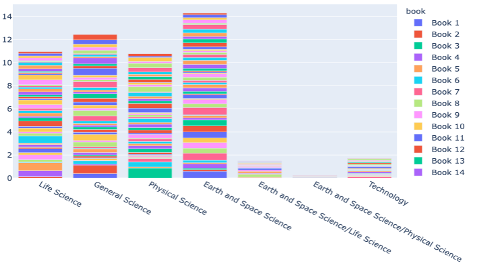
Figure 2.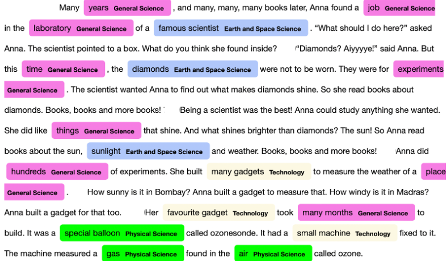

#### 5. Conclusion and Discussion

> In this study, we demonstrated the use of a named entity recognition algorithm to train and extract science concept extraction framework from children’s narrative storybooks. Due to a lack of time for this proposal, we have so far accumulated fifty science books. From limited training samples, we found evidence that highlights the various types and categories of science concepts that underlies children’s storybooks. General Science (e.g., experiments, laboratory, chart, hypothesis) and earth and space sciences (e.g., sunlight, stream, volcano) concepts were most frequently identified from the extracted concept entities. Moreover, we identified that all science encompassed various science concepts that cross multiple categories of science topics (e.g., physical sciences, life sciences) in the story. The qualitative comparisons between our science concept extraction and naive named entity extraction showed a drastic shift in the types of entities and concepts that our approach could extract. Further quantitative evaluation results will be provided based on the two human-rater agreement scores.

#### 6. References

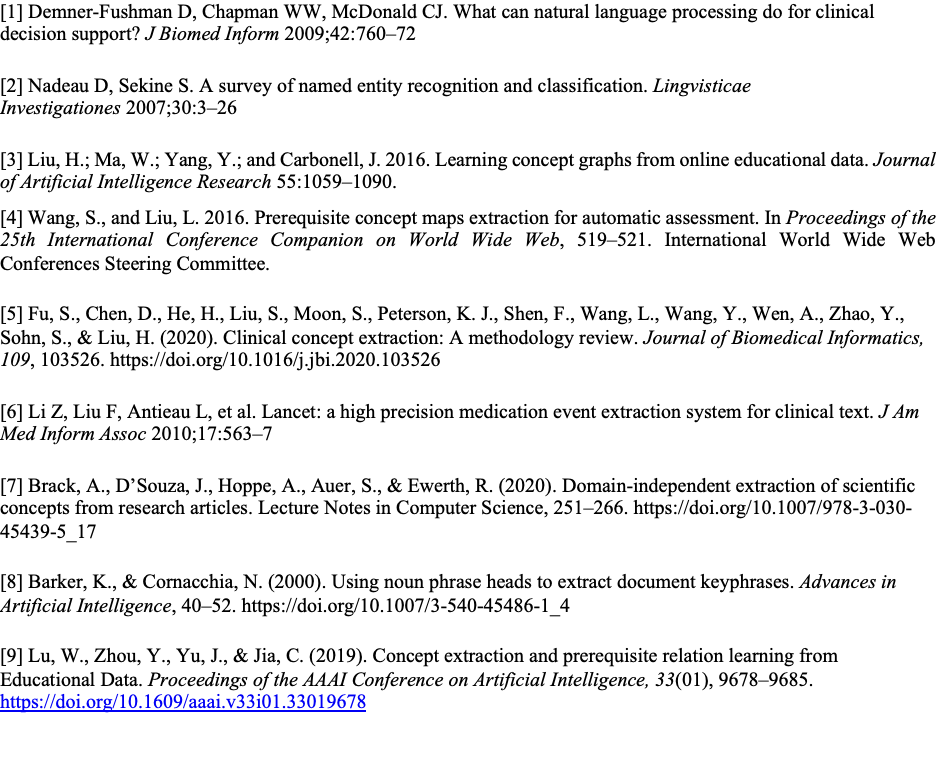